## Boring Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.DEBUG)

import json
import os
import trappy
from trace import Trace
from executor import Executor

import numpy as np
import pandas as pd

from bart.common.Utils import select_window, area_under_curve

from trappy.stats.Topology import Topology

In [2]:
from tests.eas.acceptance import ManyTasksLowestEnergy

In [3]:
events = [
            "sched_overutilized",
            "sched_migrate_task",
            "sched_load_avg_task",
            "sched_load_avg_cpu",
            "sched_switch",
            "cpu_idle",
            "cpu_frequency",
            "irq*"
        ]

In [4]:
run_workload = True

## Running Workload

In [5]:
if run_workload:
    global platform, trace_path,tasks, topology

    ManyTasksLowestEnergy.setUpClass()
    
    energy_model = ManyTasksLowestEnergy.executor.te.nrg_model
    executor = ManyTasksLowestEnergy.executor
    experiment = executor.experiments[0]
    trace_path = experiment.out_dir
    platform = executor.te.platform
    topology = platform["topology"]
    tasks = experiment.wload.tasks.keys()

04:20:46  INFO    :       LisaTest - Using configuration:
04:20:46  INFO    :       LisaTest -    /home/brendan/sources/lisa/tests/eas/many_tasks.config
04:20:46  INFO    :       LisaTest - Setup tests execution engine...
04:20:46  INFO    :         Target - Loading custom (file) test configuration
04:20:46  INFO    :         Target - Using base path: /home/brejac01/sources/lisa
04:20:46  INFO    :         Target - Loading default (file) target configuration
04:20:46  INFO    :         Target - Loading target configuration [/home/brejac01/sources/lisa/target.config]...
04:20:46  INFO    :         Target - Loading custom (file) test configuration
04:20:46  INFO    :         Target - Loading target configuration [/home/brendan/sources/lisa/tests/eas/many_tasks.config]...
04:20:46  INFO    :         Target - External tools using:
04:20:46  INFO    :         Target -    ANDROID_HOME: /work/android-sdk-linux
04:20:46  INFO    :         Target -    CATAPULT_HOME: /home/brendan/sources/lisa/t

In [17]:
def get_rtapp_params(trace_dir):
    wload_name = os.path.split(trace_dir)[-2].split("::")[-1]
    rtapp_json_path = os.path.join(trace_dir, "{}_00.json".format(wload_name))
    with open(rtapp_json_path) as f:
        rtapp_params = json.load(f)["tasks"]
    return rtapp_params
    
    topology = Topology(platform["topology"])

In [19]:
# TODO move this into the run_workload block above
topology = Topology(platform["topology"])
rtapp_params = get_rtapp_params(experiment.out_dir)

## OR, not running workload

In [6]:
from platforms.juno_energy import juno_energy
from platforms.hikey_energy import hikey_energy


if not run_workload:
    trace_path = "/home/brejac01/sources/lisa/results/20161101_142949/rtapp::two-eightypercent/1/trace.dat"
    plat_name = "hikey"
    
    trace_dir = os.path.dirname(trace_path)

    platform_json_path = os.path.join(trace_dir, "../platform.json")
    with open(platform_json_path) as f:
        platform = json.load(f)

    rtapp_params = get_rtapp_params(trace_dir)
    tasks = rtapp_params.keys()

    topology = Topology(platform["topology"])

    # todo lol
    energy_model = globals()[plat_name + "_energy"]

## Plot Schedule

In [7]:
import trappy

trace = Trace(platform, trace_path, events)

print "tracing " + os.path.realpath(trace_path)
trappy.plotter.plot_trace(trace.ftrace)

04:20:56  INFO    : Parsing FTrace format...
04:20:57  INFO    : Platform clusters verified to be Frequency coherent
04:20:57  INFO    : Collected events spans a 1.885 [s] time interval
04:20:57  INFO    : Overutilized time: 1.099901 [s] (58.339% of trace time)
04:20:57  INFO    : Set plots time range to (0.000000, 1.885346)[s]
04:20:57  INFO    : Registering trace analysis modules:
04:20:57  INFO    :    tasks
04:20:57  INFO    :    eas
04:20:57  INFO    :    latency
04:20:57  INFO    :    frequency
04:20:57  INFO    :    functions
04:20:57  INFO    :    idle
04:20:57  INFO    :    status
04:20:57  INFO    :    cpus


tracing /home/brejac01/sources/lisa/results/20161101_162049/rtapp::two-eightypercent/1


## Figure out period of workload execution

In [8]:
from bart.sched.SchedMultiAssert import SchedMultiAssert

In [11]:
multi_assert = SchedMultiAssert(trace_path,
                                topology,
                                tasks)
start = min(e['starttime'] for e in multi_assert.getStartTime().values())
end = min(e['endtime'] for e in multi_assert.getEndTime().values())
window = (start, end)
window

(0.57070799999928568, 1.5709289999995235)

## View energy estimation
`estimate_from_trace` uses the energy model to produce a trace of estimated power of each system component.
Each column is headed by a tuple with the CPUs in the component (CPU or cluster) represented. The "power" column contains the sum of the other columns.

In [12]:
power_df = energy_model.estimate_from_trace(trace)
power_df = select_window(power_df, window)

04:22:21  INFO    :    EnergyModel - Estimating energy from trace - 3942 events...
04:22:23  INFO    :    EnergyModel - Done.


Now plot the energy of each component. The `cumsum` along axis 1 (the horizontal axis) means that the plots for each component are stacked. 

Working out which line is which is left as an exercise to the reader. Also we should fill under the lines with 100% opacity but I can't get the JS library to do that for me.

# TODO 
BROKEY NO WORKY. WHY?

In [14]:
df = power_df.drop("power", 1).apply(np.cumsum, axis=1)
print df.columns
from trappy.plotter.ILinePlotGen import ILinePlotGen
gen = ILinePlotGen(2, per_line=1, title="power", 
                   max_datapoints={}, step_plot=True, fill=False, scatter=None, point_size=1000)
gen.add_plot(1, df)
gen.finish()

Index([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (0, 1, 2, 3),
       (4, 5, 6, 7)],
      dtype='object')


""
""
""
""


# ALSO TO DO
- Get rid of the stupid "power" member
- clean up the `find_optimal_placements` interface

## Find which resources over-used energy

Sum the energy used by each component over the period of workload execution.

In [15]:
df = pd.DataFrame(power_df)
estimated = {}
for column in df.columns:
    estimated[column] = area_under_curve(df[column]) / (window[1] - window[0])

# estimated["power"] should be the some of the other values (w/ rounding errors)
assert (estimated["power"] - (sum(estimated.values()) - estimated["power"])) < 0.1

print("Average estimated system power: %s bogo-Watts" % estimated["power"])

Average estimated system power: 1191.5579597 bogo-Watts


Get expected (ideal) energy usage

In [20]:
def task_capacity(task):
    # Must be a single-phase task
    [phase] = rtapp_params[task]["phases"].values()
    return (phase["run"] / float(phase["timer"]["period"]) * energy_model.capacity_scale)

capacities = {t: task_capacity(t) for t in tasks}
_, utils = energy_model._find_optimal_placements(capacities)

04:24:19  INFO    :    EnergyModel - Searching 64 configurations for optimal task placement...
04:24:19  INFO    :    EnergyModel - Done


In [21]:
def distance_sq(a, b):
    # Return the square of the distance between two n-dimensional points
    return sum([(ai - bi) ** 2 for ai, bi in zip(a, b)])
def distance_from_observed(util):
    keys = estimated.keys()
    power = energy_model.estimate_from_cpu_util(util, combine=True)
    return distance_sq([power[k] for k in keys], [estimated[k] for k in keys])

# Find the utilization distribution (task placement) that would give the most similar energy profile to the one observed
util = min(utils, key=distance_from_observed)
expected = energy_model.estimate_from_cpu_util(util, combine=True)

Show how much extra energy each component seemed to use

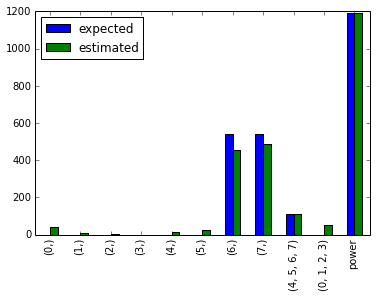

In [22]:
def df_for_graph(power):
    # Convert a dict to a DataFrame that can be used to display a bar graph
    # Order the bars by key length - so CPU-level numbers are first, then cluster numbers, then the total ("power")
    items = sorted(power.items(), key=lambda (k, v): len(k))
    [keys, vals] = zip(*items)
    return pd.DataFrame(list(vals), index=list(keys))

assert estimated.keys() == expected.keys()

df_exp = df_for_graph(expected)
df_est = df_for_graph(estimated)

df = pd.concat([df_exp, df_est], axis=1, join_axes=[df_exp.index])
df.columns = ["expected", "estimated"]
df.plot(kind="bar")

04:24:25  INFO    : LITTLE cluster average frequency: 1.169 GHz
04:24:25  INFO    : big    cluster average frequency: 1.170 GHz


(1.1694912047691473, 1.1695829301311593)

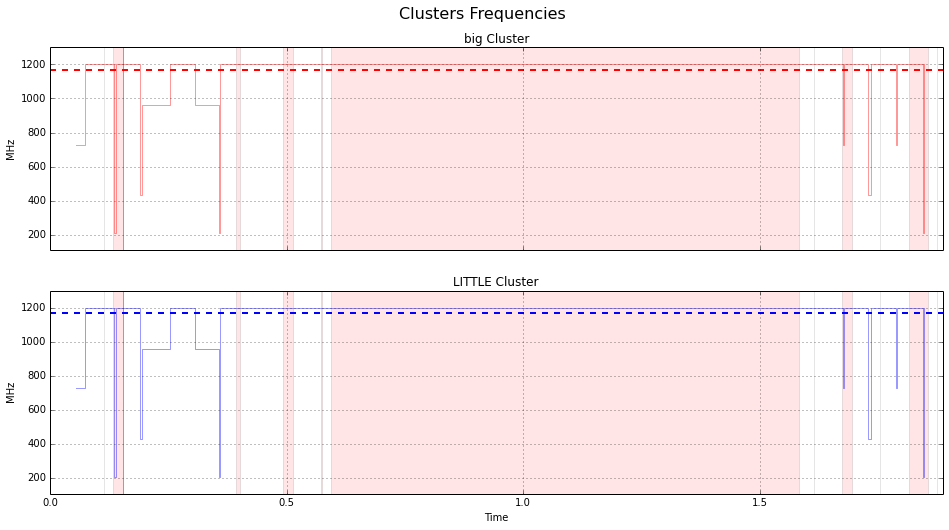

In [23]:
trace.analysis.frequency.plotClusterFrequencies()

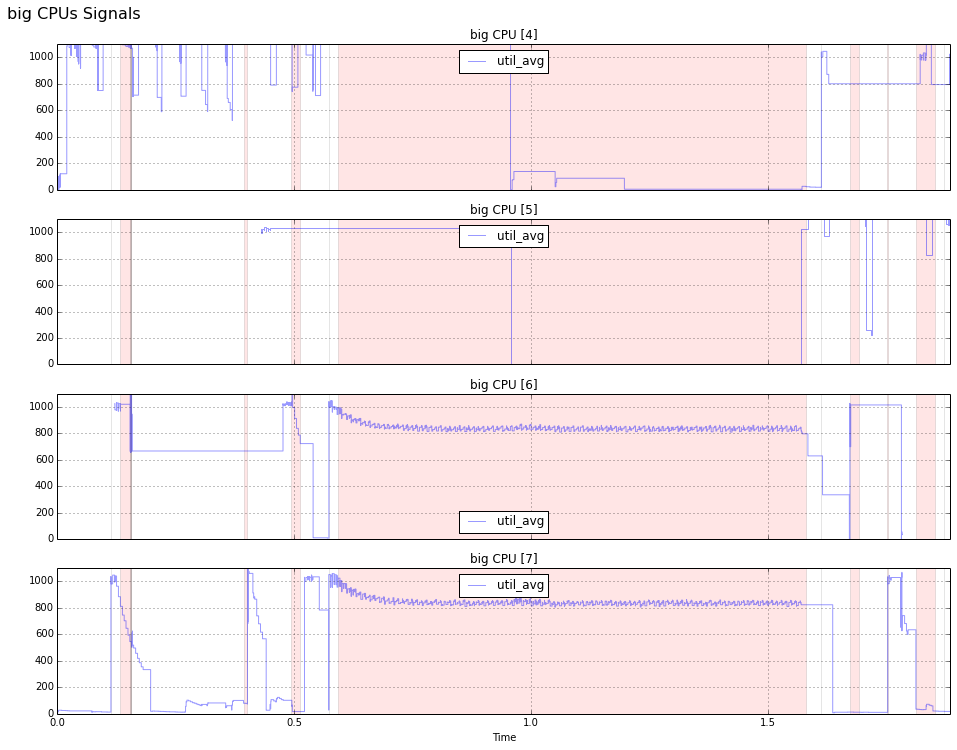

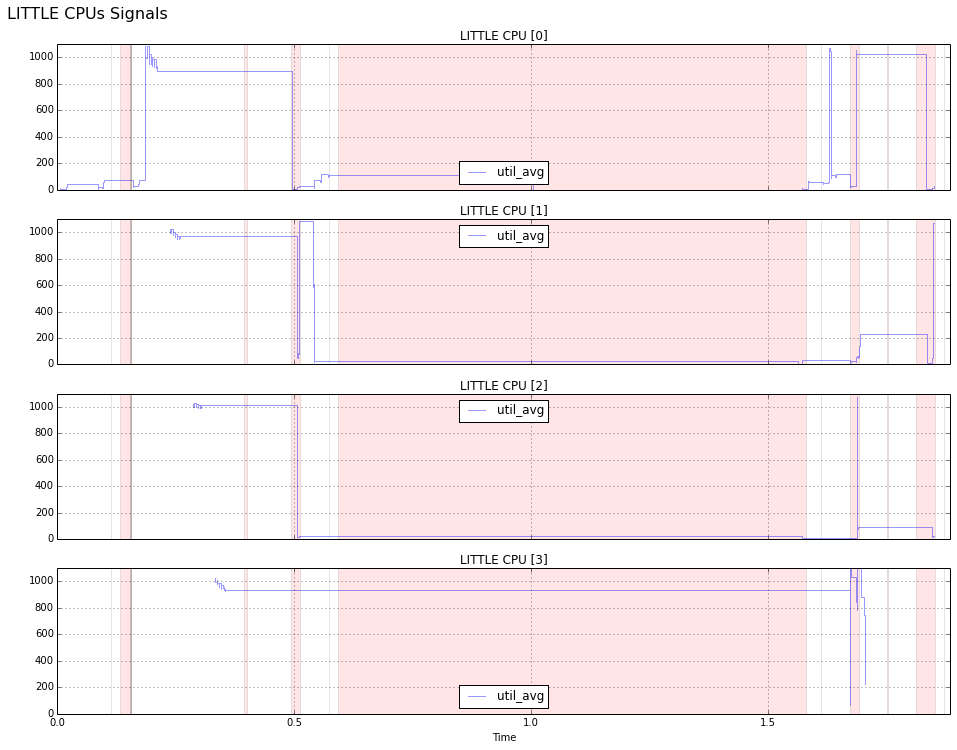

In [24]:
trace.analysis.cpus.plotCPU()

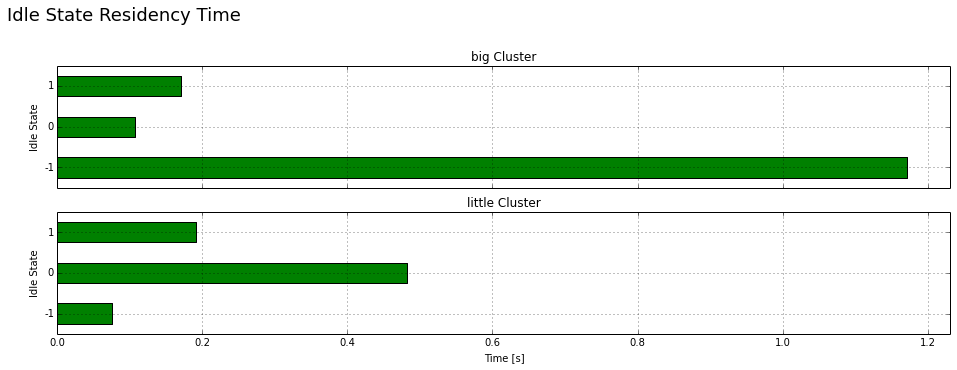

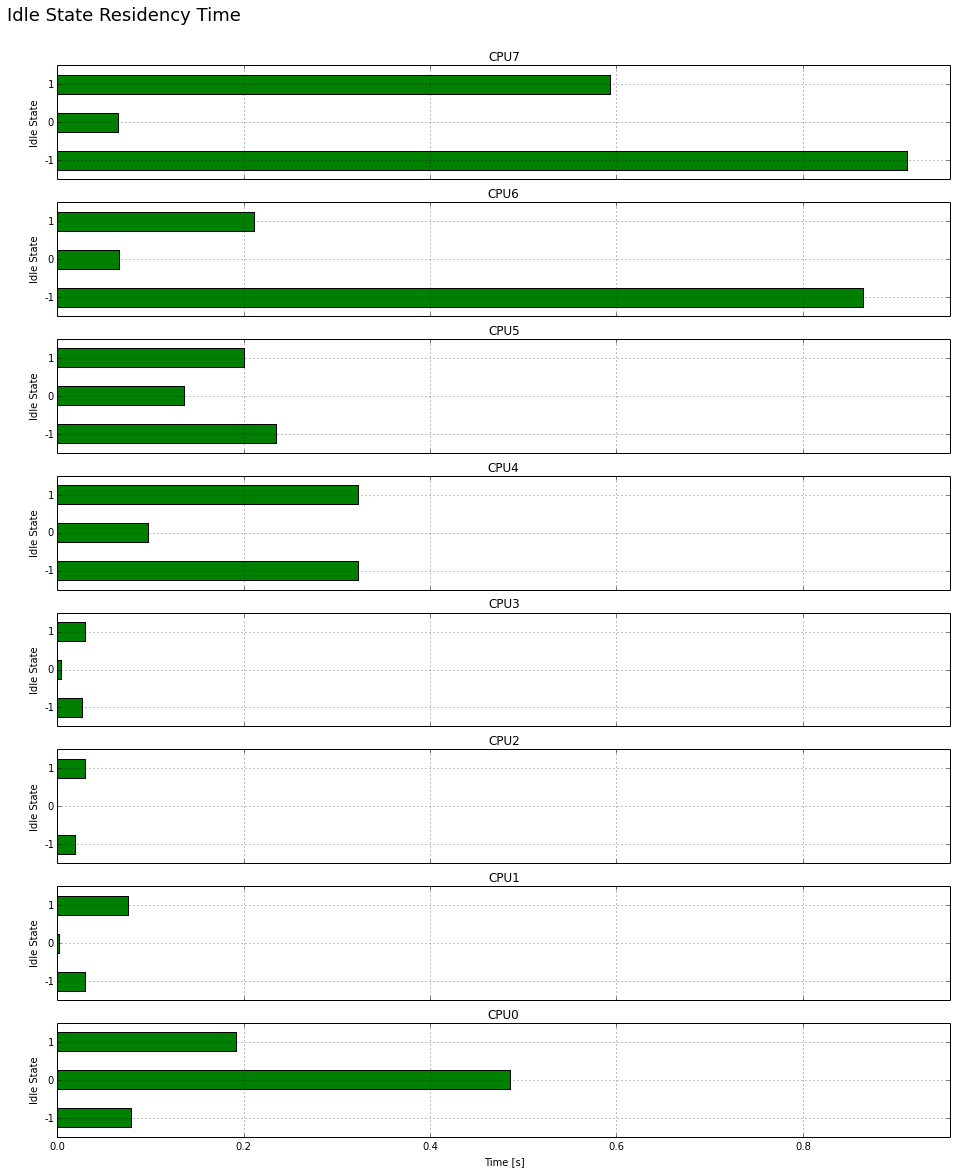

In [25]:
trace.analysis.idle.plotClusterIdleStateResidency()
trace.analysis.idle.plotCPUIdleStateResidency()